In [1]:
import pandas as pd
import numpy as np
import torch
from data_provider.data_factory import Data_Provider
import yaml, json
from utils.tools import dotdict

In [2]:
# load json
with open('checkpoints/03-11-0936_FITS_solar_day_ahead/args.json', 'r') as f:
    args = json.load(f)
args = dotdict(args)

In [3]:
# load yaml
with open('./data_configs/fullsolar_hetero.yaml') as f:
    data_config = yaml.load(f, Loader=yaml.FullLoader)
data_config = dotdict(data_config)
args.data_config = data_config

args.scale = False # disable the normalization

In [4]:
a=Data_Provider(args, buffer=(not args.disable_buffer))

[ info ] Successfully load the dynamic data from fast_general_weather_forecast_????.json


In [5]:
fullsets = a.get_val('set')

Loading val datasets:  11%|█         | 1/9 [00:00<00:05,  1.56it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_314106.parquet to buffer


Loading val datasets:  22%|██▏       | 2/9 [00:01<00:03,  1.83it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_319086.parquet to buffer


Loading val datasets:  33%|███▎      | 3/9 [00:01<00:03,  1.81it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_164440.parquet to buffer


Loading val datasets:  44%|████▍     | 4/9 [00:02<00:02,  1.76it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_355827.parquet to buffer


Loading val datasets:  56%|█████▌    | 5/9 [00:02<00:02,  1.73it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_331901.parquet to buffer


Loading val datasets:  67%|██████▋   | 6/9 [00:03<00:01,  1.81it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_332785.parquet to buffer


Loading val datasets:  78%|███████▊  | 7/9 [00:03<00:01,  1.78it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_577650.parquet to buffer


Loading val datasets:  89%|████████▉ | 8/9 [00:04<00:00,  1.87it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_551172.parquet to buffer


Loading val datasets: 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_570079.parquet to buffer


In [6]:
fullsets.keys()

dict_keys(['314106', '319086', '164440', '355827', '331901', '332785', '577650', '551172', '570079'])

In [7]:
seta = fullsets['314106']
len(seta)

8569

In [8]:
instance = seta[2000-144]

In [9]:
instance[4]

'[{"daily":"It\'s going to be a beautiful day in March, with a mix of sunshine and passing clouds. Temperatures will be mild, ranging from 4 to 14 degrees Celsius. Expect a gentle breeze blowing from the south to the north, with wind speeds of around 20-30 km\\/h. As the day progresses, the humidity will decrease, making it a pleasant day to be outdoors. However, be prepared for scattered showers in the late evening, with a chance of partly cloudy skies.","Early Morning":"Early morning will be cool and calm, with temperatures ranging from 4 to 7 degrees Celsius. Expect passing clouds and a gentle breeze blowing from the south to the north, with wind speeds of around 10-20 km\\/h. It\'s a great time to get outside and enjoy the fresh air!","Morning":"Morning will be partly cloudy, with temperatures ranging from 7 to 12 degrees Celsius. Expect a gentle breeze blowing from the south to the north, with wind speeds of around 20-30 km\\/h. It\'s a great time to get outside and enjoy the suns

## try with openai API

In [ ]:
# ts_x, ts_y, tm_x, tm_y, (dy_tm_x, general, channel, [dy_x]), (dy_tm_y, general, channel, [dy_y])

In [10]:
import openai

In [11]:
openai.base_url = 'http://localhost:8021/v1/'
openai.api_key = 'EMPTY'

In [ ]:
system_prompt = "You are a professonal data analyst. You can do the forecasting by considering the historical time series readings along with weather condition and make the prediction for the next 24 hours. " + seta[2000][4][1] + "Please directly do the forecasting without any further external tools such as coding. You can consider the periodicity, trend, and seasonality of the data. Then consider the affect of weather condition to further refine your prediction. The time period are defined as follows, 0~6 as Early morning, 7~12 as Morning, 13~18 as Afternoon, 19~24 as Evening. "


In [25]:
x_ts = instance[0].squeeze().tolist()
x_timestamp = instance[2].tolist()
x_table = [(x_timestamp[i], x_ts[i]) for i in range(len(x_ts))]

x_dy = instance[4][-1]
x_dy_timestamp = instance[4][0]
x_dy_table = [(x_dy_timestamp[i], x_dy[i]) for i in range(len(x_dy))]

channel_info = instance[4][2]
channel_info

'The solar panel is located at Calgary Fire Hall Headquarters.'

In [26]:
y_ts = instance[1].squeeze().tolist()
y_timestamp = instance[3].tolist()

y_dy = instance[5][-1]
y_dy_timestamp = instance[5][0]
y_dy_table = [(y_dy_timestamp[i], y_dy[i]) for i in range(len(y_dy))]
y_dy_table

[('20210326000000',
  '{"daily":"It\'s going to be a chilly day in March, with a mix of light snow and ice fog. The temperature will fluctuate between -5\\u00b0C and 2\\u00b0C, with a general trend of warming up slightly towards the end of the day. Expect mostly cloudy skies with some scattered clouds and snow flurries. The wind will be moderate to strong, blowing from various directions. It\'s a good idea to bundle up and stay warm!","Early Morning":"Early morning will be quite chilly, with temperatures around -5\\u00b0C. Expect light snow and ice fog, with moderate winds blowing from the east-southeast. It\'s a good idea to dress warmly and stay indoors if possible.","Morning":"Morning will see a slight warming trend, with temperatures rising to around -2\\u00b0C. Expect light snow and broken clouds, with moderate winds blowing from the south. It\'s a good idea to take a warm drink with you on your way out.","Afternoon":"Afternoon will be quite pleasant, with temperatures rising to a

In [27]:
user_prompt = f'''

We now have the data from {channel_info}. The historical data is as follows:

{x_table}

The historical weather condition is as follows:

{x_dy_table}

We now have the weather forecasting for the following days:

{y_dy_table}

Please make the prediction for the next 24 hours.

The timestamp for forecasting is as follows:

{y_timestamp}

Please format it in json format in [datastamp, value] pair, as below:

```json

[[<timestamp>, <predicted_value>],
 [<timestamp>, <predicted_value>],
 ...]

```
'''

In [28]:
messages = [
    {'role': 'system', 'content': system_prompt},
    {'role': 'user', 'content': user_prompt}
]

In [29]:
avaliable_models = openai.models.list()
avaliable_models = [model.id for model in avaliable_models.data]
avaliable_models

['Qwen/QwQ-32B']

In [30]:
import re

In [31]:
def extract_result(result):
    pattern = r'```json(.*?)```'
    result = re.search(pattern, result, re.DOTALL)
    pred = json.loads(result.group(1))

    return pred

In [32]:
# do multi processing
import multiprocessing

def call_openai(model_id, messages):
    temp = 0.2
    # if 'DeepSeek' in model_id:
    messages[1]['content']=messages[0]['content']+messages[1]['content']
    messages[0]['content']=''
    temp = 0.6
    response = openai.chat.completions.create(
        model=model_id,
        messages=messages,
        temperature=temp,
    )
    extracted = extract_result(response.choices[0].message.content)
    return extracted, response.choices[0].message.content, model_id
    # return response.choices[0].message.content

pool = multiprocessing.Pool(processes=4)
results = pool.starmap(call_openai, [(model_id, messages) for model_id in avaliable_models])

In [33]:
results

[([['20210326080000', 0.4],
   ['20210326090000', 1.0],
   ['20210326100000', 2.5],
   ['20210326110000', 3.8],
   ['20210326120000', 4.5],
   ['20210326130000', 4.0],
   ['20210326140000', 3.2],
   ['20210326150000', 2.5],
   ['20210326160000', 1.8],
   ['20210326170000', 1.0],
   ['20210326180000', 0.4],
   ['20210326190000', 0.1],
   ['20210326200000', 0.0],
   ['20210326210000', 0.0],
   ['20210326220000', 0.0],
   ['20210326230000', 0.0],
   ['20210327000000', 0.0],
   ['20210327010000', 0.0],
   ['20210327020000', 0.0],
   ['20210327030000', 0.0],
   ['20210327040000', 0.0],
   ['20210327050000', 0.0],
   ['20210327060000', 0.0],
   ['20210327070000', 0.01]],
  '<think>\nOkay, let\'s tackle this forecasting problem. So, the user wants me to predict the next 24 hours of solar power generation for the Calgary Fire Hall Headquarters solar panels. They provided historical data from March 19 to March 25, 2021, along with weather conditions and forecasts for March 26 and 27. I need to 

In [34]:
import matplotlib.pyplot as plt

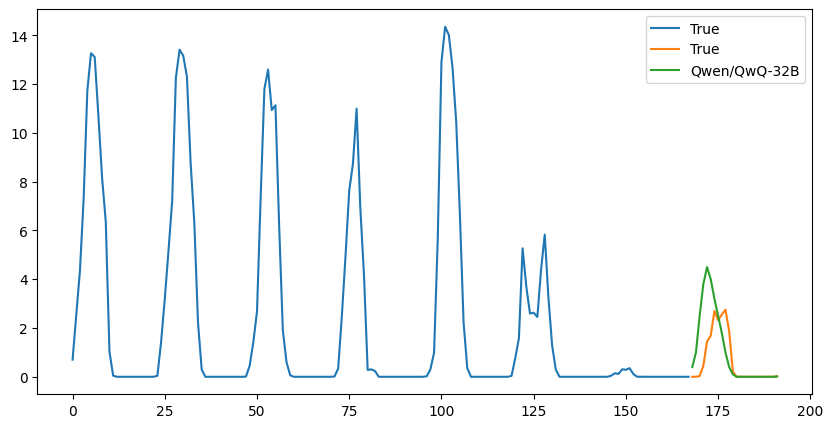

In [35]:
%matplotlib inline

plt.figure(figsize=(10, 5))

plt.plot(np.arange(len(x_ts)), x_ts, label='True')

plt.plot(np.arange(len(x_ts), len(x_ts)+len(y_ts)), y_ts, label='True')

for result in results:
    pred = result[0][:24]
    model_id = result[2]
    plt.plot(np.arange(len(x_ts), len(x_ts)+len(y_ts)), [x[1] for x in pred], label=model_id)





plt.legend()

plt.show()


In [98]:
user_prompt

'\n\nWe now have the data from The solar panel is located at Calgary Fire Hall Headquarters.. The historical data is as follows:\n\n[(20210325080000, 0.0), (20210325090000, 0.0), (20210325100000, 0.043), (20210325110000, 0.145), (20210325120000, 0.118), (20210325130000, 0.307), (20210325140000, 0.286), (20210325150000, 0.354), (20210325160000, 0.118), (20210325170000, 0.003), (20210325180000, 0.0), (20210325190000, 0.0), (20210325200000, 0.0), (20210325210000, 0.0), (20210325220000, 0.0), (20210325230000, 0.0), (20210326000000, 0.0), (20210326010000, 0.0), (20210326020000, 0.0), (20210326030000, 0.0), (20210326040000, 0.0), (20210326050000, 0.0), (20210326060000, 0.0), (20210326070000, 0.0), (20210326080000, 0.0), (20210326090000, 0.0), (20210326100000, 0.032), (20210326110000, 0.457), (20210326120000, 1.448), (20210326130000, 1.681), (20210326140000, 2.697), (20210326150000, 2.321), (20210326160000, 2.547), (20210326170000, 2.752), (20210326180000, 1.87), (20210326190000, 0.216), (202